# Imports and preparation

In [1]:
import os

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
from tqdm import tqdm

In [5]:
import time, gc

In [6]:
import importlib

In [7]:
from itertools import product


In [8]:
from util import util_elastic

OpenAI tiktoken module is not available for Python < 3.8,Linux ARM64 and AARCH64. Falling back to GPT2TokenizerFast.


In [9]:
from util import util_pipeline_v2 as util_pipeline

In [10]:
from util import util_experiment_juris_tcu as util_experiment

In [11]:
# Para ter repetibilidade nos resultados
random_state = 1

# Tratar valores infinitos (+ e -) como np.NaN
pd.options.mode.use_inf_as_na = True

# IMPORTANTE para tornar figuras interativas
# %matplotlib notebook

# Tamanho padrão das figuras
figsize=(10,6)

pd.set_option('display.max_row', 1000)

pd.set_option('display.max_columns', 50)

pd.set_option('display.column_space', 100)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.width', 200)


In [12]:
DATASET_NAME = 'juris_tcu'

In [13]:
PATH_QUERY = f'../data/{DATASET_NAME}/query.csv'
PATH_QREL =  f'../data/{DATASET_NAME}/qrel.csv'

# Data load

## Query data load

In [14]:
df_query = pd.read_csv(PATH_QUERY)

In [15]:
df_query.shape

(150, 3)

In [16]:
df_query.head()

,ID,TEXT,SOURCE
0,1,técnica e preço,search log
1,2,restos a pagar,search log
2,3,aditivo a contrato,search log
3,4,adesão a ata de registro de preços,search log
4,5,sobrepreço e superfaturamento,search log


In [17]:
df_query = df_query.reset_index(drop=True)

In [18]:
# df_query.to_csv(PATH_QUERY,sep=',', index=False)

## Qrel data load

In [19]:
df_qrel = pd.read_csv(PATH_QREL)

In [20]:
df_qrel.shape

(2250, 5)

In [21]:
df_qrel.head(15)

,QUERY_ID,DOC_ID,SCORE,ENGINE,RANK
0,1,21064,3,(BM25|STS)+Reranker+LLM,1
1,1,42166,3,(BM25|STS)+Reranker+LLM,2
2,1,13702,3,(BM25|STS)+Reranker+LLM,3
3,1,20592,3,(BM25|STS)+Reranker+LLM,4
4,1,15740,3,(BM25|STS)+Reranker+LLM,5
5,1,53641,3,(BM25|STS)+Reranker+LLM,6
6,1,31601,3,(BM25|STS)+Reranker+LLM,7
7,1,54765,3,(BM25|STS)+Reranker+LLM,8
8,1,20506,3,(BM25|STS)+Reranker+LLM,9
9,1,47161,3,(BM25|STS)+Reranker+LLM,10


In [22]:
df_qrel.shape[0]

2250

In [23]:
df_search_data = df_query.merge(df_qrel, how='left', left_on='ID', right_on='QUERY_ID').drop('QUERY_ID', axis=1)

In [24]:
df_search_data.shape


(2250, 7)

In [25]:
# Agrupar os dados pelo ID e criar a coluna 'RELEVANCE_LIST' com a lista de tuplas
# df_new = df_search_data.groupby('ID').apply(lambda x: list(zip(x['DOC_ID'], x['TYPE']))).reset_index(name='RELEVANCE_LIST')
# df_new['RELEVANCE_LIST'] = df_new['RELEVANCE_LIST'].apply(lambda x: sorted(x, key=lambda tup: ('AREA', 'TEMA', 'SUBTEMA', 'INDEXACAO_EXTRA').index(tup[1])))
df_new = df_search_data.groupby('ID').apply(lambda x: dict(zip(x['DOC_ID'], x['SCORE']))).reset_index(name='RELEVANCE_DICT')


In [26]:
df_new.head()

,ID,RELEVANCE_DICT
0,1,"{21064: 3, 42166: 3, 13702: 3, 20592: 3, 15740: 3, 53641: 3, 31601: 3, 54765: 3, 20506: 3, 47161: 3, 161: 1, 11595: 1, 40647: 1, 22155: 1, 18435: 1}"
1,2,"{31437: 3, 19340: 3, 77959: 3, 17289: 2, 18452: 2, 18105: 1, 19636: 1, 31274: 0, 17258: 0, 32865: 0, 19738: 0, 104484: 0, 90647: 0, 21876: 0, 33096: 0}"
2,3,"{18380: 3, 31102: 3, 17240: 3, 20511: 3, 32589: 3, 20510: 3, 17816: 3, 18058: 2, 17225: 2, 57354: 2, 18003: 2, 3881: 2, 31096: 1, 20901: 1, 11621: 1}"
3,4,"{16895: 3, 45015: 3, 14526: 3, 62306: 3, 6237: 3, 50537: 3, 16981: 3, 21201: 3, 77927: 3, 84935: 3, 22098: 1, 18410: 1, 8858: 1, 60811: 0, 42906: 0}"
4,5,"{21172: 3, 17816: 3, 4066: 3, 53003: 3, 94290: 3, 114656: 3, 50616: 3, 144170: 3, 16277: 3, 59226: 3, 18047: 2, 31612: 1, 18036: 1, 42583: 0, 29387: 0}"


In [27]:
# Unir o resultado com as demais colunas únicas
df_new = pd.merge(df_new, df_search_data.drop_duplicates('ID'), on='ID', how='left')

In [28]:
df_new.columns

Index(['ID', 'RELEVANCE_DICT', 'TEXT', 'SOURCE', 'DOC_ID', 'SCORE', 'ENGINE', 'RANK'], dtype='object')

In [29]:
df_search_data = df_new[['ID', 'TEXT', 'RELEVANCE_DICT',  'SOURCE']]

In [30]:
df_search_data.shape

(150, 4)

In [31]:
df_search_data = df_search_data.reset_index()

In [32]:
df_search_data.head()

,index,ID,TEXT,RELEVANCE_DICT,SOURCE
0,0,1,técnica e preço,"{21064: 3, 42166: 3, 13702: 3, 20592: 3, 15740: 3, 53641: 3, 31601: 3, 54765: 3, 20506: 3, 47161: 3, 161: 1, 11595: 1, 40647: 1, 22155: 1, 18435: 1}",search log
1,1,2,restos a pagar,"{31437: 3, 19340: 3, 77959: 3, 17289: 2, 18452: 2, 18105: 1, 19636: 1, 31274: 0, 17258: 0, 32865: 0, 19738: 0, 104484: 0, 90647: 0, 21876: 0, 33096: 0}",search log
2,2,3,aditivo a contrato,"{18380: 3, 31102: 3, 17240: 3, 20511: 3, 32589: 3, 20510: 3, 17816: 3, 18058: 2, 17225: 2, 57354: 2, 18003: 2, 3881: 2, 31096: 1, 20901: 1, 11621: 1}",search log
3,3,4,adesão a ata de registro de preços,"{16895: 3, 45015: 3, 14526: 3, 62306: 3, 6237: 3, 50537: 3, 16981: 3, 21201: 3, 77927: 3, 84935: 3, 22098: 1, 18410: 1, 8858: 1, 60811: 0, 42906: 0}",search log
4,4,5,sobrepreço e superfaturamento,"{21172: 3, 17816: 3, 4066: 3, 53003: 3, 94290: 3, 114656: 3, 50616: 3, 144170: 3, 16277: 3, 59226: 3, 18047: 2, 31612: 1, 18036: 1, 42583: 0, 29387: 0}",search log


In [33]:
del df_new

# Create reference to index (elastic search)

Documentation https://docs.haystack.deepset.ai/docs
https://haystack.deepset.ai/tutorials/09_dpr_training 


In [34]:
index_dict = util_elastic.return_indexes('indir', parm_print=True)

Index: indir_juris_tcu
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu', 'uuid': 'RD_aAWppQH6vjNxKUdL_0w', 'pri': '1', 'rep': '1', 'docs.count': '16045', 'docs.deleted': '16045', 'store.size': '334.9mb', 'pri.store.size': '334.9mb'}

Index: indir_juris_tcu_term
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu_term', 'uuid': 'S5WlNGiqSXC-79WaqfsddA', 'pri': '1', 'rep': '1', 'docs.count': '16045', 'docs.deleted': '16045', 'store.size': '337.5mb', 'pri.store.size': '337.5mb'}

Index: indir_juris_tcu_related_term
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu_related_term', 'uuid': 'i9nzlBQrREyEC7MGT79GBQ', 'pri': '1', 'rep': '1', 'docs.count': '16045', 'docs.deleted': '3651', 'store.size': '346.3mb', 'pri.store.size': '346.3mb'}

Index: indir_juris_tcu_synonym_related_term
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu_synonym_related_term', 'uuid': 'OJIJ0P2XQo-s4NRuaT4W_w', 'pri': '1', 'rep': '1', 'docs.count': '16045',

In [35]:
index_dict

{'indir_juris_tcu': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu',
  'uuid': 'RD_aAWppQH6vjNxKUdL_0w',
  'pri': '1',
  'rep': '1',
  'docs.count': '16045',
  'docs.deleted': '16045',
  'store.size': '334.9mb',
  'pri.store.size': '334.9mb'},
 'indir_juris_tcu_term': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu_term',
  'uuid': 'S5WlNGiqSXC-79WaqfsddA',
  'pri': '1',
  'rep': '1',
  'docs.count': '16045',
  'docs.deleted': '16045',
  'store.size': '337.5mb',
  'pri.store.size': '337.5mb'},
 'indir_juris_tcu_related_term': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu_related_term',
  'uuid': 'i9nzlBQrREyEC7MGT79GBQ',
  'pri': '1',
  'rep': '1',
  'docs.count': '16045',
  'docs.deleted': '3651',
  'store.size': '346.3mb',
  'pri.store.size': '346.3mb'},
 'indir_juris_tcu_synonym_related_term': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu_synonym_related_term',
  'uuid': 'OJIJ0P2XQo-s4NRuaT4W_w'

In [36]:
list_name_index = ['indir_juris_tcu', 'indir_juris_tcu_term', 'indir_juris_tcu_synonym', 'indir_juris_tcu_related_term', 'indir_juris_tcu_synonym_related_term' ]

In [37]:
reference_data_index = {}

In [38]:
%%time
for index_name in list_name_index:
    reference_data_index[index_name] = util_elastic.return_index(parm_index_name=index_name, parm_embedding_dim=1024)


Qtd de documentos 16045

Qtd de embeddings 16045

Documento.id=5: <Document: id=5, content='SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial com fu...'>

Qtd de documentos 16045

Qtd de embeddings 16045

Documento.id=5: <Document: id=5, content='SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial com fu...'>

Qtd de documentos 16045

Qtd de embeddings 16045

Documento.id=5: <Document: id=5, content='SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial com fu...'>

Qtd de documentos 16045

Qtd de embeddings 16045

Documento.id=5: <Document: id=5, content='SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial com fu...'>

Qtd de documentos 16045

Qtd de embeddings 16045

Documento.id=5: <Document: id=5, content='SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial com fu...'>
CPU t

# Pipelines creation

In [39]:
# Test query
# parm_query = "trata-se de uma denúncia contra o prefeito de Manhuaçu por não haver pago os funcionários da área de limpeza urbana"
parm_query = "despesa sem cobertura contratual"

pipes = {}
pipes['index'] = {}
pipes['retriever_type'] = {}
pipes['ranker_type'] = {}
pipes['index_name'] = {}
pipes['pipe'] = {}

In [40]:
pipes = {}
for index_name in list_name_index:
    pipes[index_name] = []


In [43]:
ranker_type = 'MINILM_INDIR' # 'MT5_3B' # 'MT5_TRAINED_LIM50_800' # 'MINILM_TRAINED_19000'

In [41]:
raise Exception("Stop here")

Exception: Stop here

## Only retrievers

### bm25

In [ ]:
%%time
for index_name in list_name_index:
    pipe = {}
    pipe['PIPE_OBJECT'] = util_pipeline.return_pipeline_bm25(reference_data_index[index_name])
    pipe['RETRIEVER_TYPE'] = 'bm25'
    pipe['RANKER_TYPE'] = 'none'
    pipe['RANKER_MODEL_NAME'] = ''
    pipe['RETRIEVER_MODEL_NAME'] = ''
    pipes[index_name].append(pipe)


CPU times: user 1.17 ms, sys: 0 ns, total: 1.17 ms
Wall time: 1.17 ms


In [ ]:
%%time
for index_name in pipes:
    print(f"\nindex_name {index_name}")
    for pipe in pipes[index_name]:
        print(f"*** retriever:{pipe['RETRIEVER_TYPE']} / ranker:{pipe['RANKER_TYPE']}")
        doctos_retornados_ranker =  pipe['PIPE_OBJECT'].run(query=parm_query, 
        params={"Retriever": {"top_k": 100}})
        print(f'\nIndex: {index_name}')
        util_pipeline.detail_document_found(doctos_retornados_ranker,5)


index_name indir_juris_tcu
*** retriever:bm25 / ranker:none

Index: indir_juris_tcu
Parâmetros usados: {'Retriever': {'top_k': 100}}
Consulta: despesa sem cobertura contratual
Qtd documentos retornados: 100
Seguem os nomes dos termos recuperados em ordem de score
0 : [0.9497785738073338, '18384', 'A realização de pagamentos em data anterior à celebração do contrato caracteriza despesa sem cobertura contratual.']
1 : [0.9172683438466377, '17993', 'O pagamento pela realização de serviços novos, não contidos no projeto originalmente licitado, utilizando-se para faturamento serviços constantes na planilha de preços original, sem a respectiva execução, é despesa sem cobertura contratual, a justificar aplicação de multa aos responsáveis envolvidos.']
2 : [0.8962556736040861, '18905', 'A execução de serviços sem cobertura contratual, mas autorizados pela Administração, gera o dever de indenizar.']
3 : [0.889172123906067, '18950', 'A realização de pagamentos previamente à assinatura dos respe

### join

#### sts + bm25

In [ ]:
%%time
pipe_join_sts_bm25 = util_pipeline.return_pipeline_join_bm25_sts(index)

NameError: name 'index' is not defined

In [ ]:
pipes.append({'PIPE_NAME': 'pipe_join_sts_bm25',
              'PIPE_OBJECT': pipe_join_sts_bm25,
              'RETRIEVER_TYPE': 'join_sts_bm25',  # in ['sts', 'bm25']
              'RETRIEVER_MODEL_NAME': util_pipeline.nome_modelo_embedding_model_sts, # or nome_modelo_embedding_model_sts_rufimelo,
              'RANKER_MODEL_NAME': ''})

In [ ]:
%%time
doctos_retornados_ranker = pipe_join_sts_bm25.run(query=parm_query, 
 params={"Bm25Retriever": {"top_k": 300}, "StsRetriever": {"top_k": 300}})
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {'Bm25Retriever': {'top_k': 300}, 'StsRetriever': {'top_k': 300}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 542
Primeiro docto:
<Document: id=1102005, content='O termo é "Plano de contratações".
Plano de contratações tem definição: "É o documento no qual a org...'>

Último (542):
<Document: id=1103641, content='O termo é "Falta grave".
Falta grave tem nota de escopo: "Está prevista em várias normatizações que ...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Plano de contratações', '1102005', 0.981894035831847]
1 : ['Competência do TCU', '5095', 0.981022770821533]
2 : ['Nexo de causalidade', '4495', 0.9782476752974565]
3 : ['Teletrabalho', '5949', 0.977450618284214]
4 : ['Papéis de trabalho', '15181', 0.976140477988525]
5

In [ ]:
%%time
pipe_join_sts_multihop_bm25 = util_pipeline.return_pipeline_join_bm25_sts_multihop(index)

CPU times: user 3.36 s, sys: 674 ms, total: 4.04 s
Wall time: 2.12 s


In [ ]:
pipes.append({'PIPE_NAME': 'pipe_join_sts_multihop_bm25',
              'PIPE_OBJECT': pipe_join_sts_multihop_bm25,
              'RETRIEVER_TYPE': 'join_sts_multihop_bm25',  # in ['sts', 'bm25']
              'RETRIEVER_MODEL_NAME': util_pipeline.nome_modelo_embedding_model_sts, # or nome_modelo_embedding_model_sts_rufimelo,
              'RANKER_MODEL_NAME': ''})

In [ ]:
%%time
doctos_retornados_ranker = pipe_join_sts_multihop_bm25.run(query=parm_query, 
 params={"Bm25Retriever": {"top_k": 150}, "StsRetriever": {"top_k": 150}})
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {'Bm25Retriever': {'top_k': 150}, 'StsRetriever': {'top_k': 150}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 289
Primeiro docto:
<Document: id=2577, content='O termo é "Afastamento de responsável".
Afastamento de responsável tem definição: "No início ou no c...'>

Último (289):
<Document: id=1102397, content='O termo é "Estado de exceção".
Estado de exceção tem nota de escopo: "Situação oposta ao Estado demo...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Afastamento de responsável', 0.9930839884285582]
1 : ['Plano de contratações', 0.9856940203493179]
2 : ['Competência do TCU', 0.9849874794705751]
3 : ['Teletrabalho', 0.9823437136689326]
4 : ['Nexo de causalidade', 0.982157658932855]
5 : ['Processo administrativo de resp

In [ ]:
%%time
pipe_sts_multihop = util_pipeline.return_pipeline_sts_multihop(index)

CPU times: user 3.39 s, sys: 715 ms, total: 4.11 s
Wall time: 2.16 s


In [ ]:
pipes.append({'PIPE_NAME': 'pipe_sts_multihop',
              'PIPE_OBJECT': pipe_sts_multihop,
              'RETRIEVER_TYPE': 'sts_multihop',  # in ['sts', 'bm25']
              'RETRIEVER_MODEL_NAME': util_pipeline.nome_modelo_embedding_model_sts, # or nome_modelo_embedding_model_sts_rufimelo,
              'RANKER_MODEL_NAME': ''})

In [ ]:
%%time
doctos_retornados_ranker = pipe_sts_multihop.run(query=parm_query, 
 params={"Retriever": {"top_k": 300}})
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {'Retriever': {'top_k': 300}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 300
Primeiro docto:
<Document: id=2577, content='O termo é "Afastamento de responsável".
Afastamento de responsável tem definição: "No início ou no c...'>

Último (300):
<Document: id=2550, content='O termo é "Declaração de nulidade".
Declaração de nulidade tem definição: "Declaração que torna o co...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Afastamento de responsável', 0.9930839884285582]
1 : ['Rescisão unilateral', 0.9748706914060489]
2 : ['Afastamento preventivo', 0.9741557736812957]
3 : ['Perda de objeto', 0.9725962719359168]
4 : ['Abandono de cargo', 0.9696305808093489]
5 : ['Responsabilidade perante o controle externo', 0.9692663708644913]


### sts

In [ ]:
%%time
pipe_sts = util_pipeline.return_pipeline_sts(index)

CPU times: user 3.39 s, sys: 656 ms, total: 4.05 s
Wall time: 2.1 s


In [ ]:
pipes.append({'PIPE_NAME': 'pipe_sts',
              'PIPE_OBJECT': pipe_sts,
              'RETRIEVER_TYPE': 'sts',  # in ['sts', 'bm25']
              'RETRIEVER_MODEL_NAME': util_pipeline.nome_modelo_embedding_model_sts, # or nome_modelo_embedding_model_sts_rufimelo,
              'RANKER_MODEL_NAME': ''})

In [ ]:
%%time
doctos_retornados_ranker = pipe_sts.run(query=parm_query, 
 params={"Retriever": {"top_k": 300}})
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {'Retriever': {'top_k': 300}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 300
Primeiro docto:
<Document: id=2577, content='O termo é "Afastamento de responsável".
Afastamento de responsável tem definição: "No início ou no c...'>

Último (300):
<Document: id=1103641, content='O termo é "Falta grave".
Falta grave tem nota de escopo: "Está prevista em várias normatizações que ...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Afastamento de responsável', '2577', 0.9546168861748239]
1 : ['Risco de controle', '1101311', 0.943127201770828]
2 : ['Vazamento de dados', '1110487', 0.942404112002669]
3 : ['Trancamento das contas', '2663', 0.9341491636096659]
4 : ['Revisão de ofício', '15291', 0.9297291992714615]
5 : ['Responsabilidade 

## With rankers

In [ ]:
importlib.reload(util_pipeline)

<module 'util.util_pipeline_v2' from '/home/borela/fontes/ind-ir/code/util/util_pipeline_v2.py'>

### First stage = BM25

In [ ]:
%%time
for index_name in list_name_index:
    pipe = {}
    pipe['PIPE_OBJECT'] = util_pipeline.return_pipeline_bm25_reranker(reference_data_index[index_name], ranker_type, 
                                parm_limit_query_size=50)
    pipe['RETRIEVER_TYPE'] = 'bm25'
    pipe['RANKER_TYPE'] = ranker_type
    pipe['RANKER_MODEL_NAME'] = ''
    pipe['RETRIEVER_MODEL_NAME'] = ''
    pipes[index_name].append(pipe)


Loading MINILM_INDIR with limit_query_size=50
CPU times: user 5.39 s, sys: 1.43 s, total: 6.82 s
Wall time: 4.7 s


In [ ]:

%%time
for index_name in pipes:
    print(f"\nindex_name {index_name}")
    for pipe in pipes[index_name]:
        print(f"*** retriever:{pipe['RETRIEVER_TYPE']} / ranker:{pipe['RANKER_TYPE']}")
        doctos_retornados_ranker =  pipe['PIPE_OBJECT'].run(query=parm_query, 
        params={"Retriever": {"top_k": 100}})
        print(f'\nIndex: {index_name}')
        util_pipeline.detail_document_found(doctos_retornados_ranker,5)
        torch.cuda.empty_cache()


index_name indir_juris_tcu
*** retriever:bm25 / ranker:MINILM_INDIR

Index: indir_juris_tcu
Parâmetros usados: {'Retriever': {'top_k': 100}}
Consulta: despesa sem cobertura contratual
Qtd documentos retornados: 100
Seguem os nomes dos termos recuperados em ordem de score
0 : [0.7853959798812866, '19451', 'A realização de despesas sem cobertura contratual é irregularidade grave, que justifica a aplicação de multa aos responsáveis, bem como julgamento pela irregularidade de suas contas']
1 : [0.7202020883560181, '17825', 'Pagamentos sem cobertura contratual ou prévio empenho constituem afronta à legislação ordinária, ressalvando-se, no que diz respeito à Lei 8.666/1993, os contratos verbais destinados às compras de pronto pagamento, feitas em regime de adiantamento, em valores não superiores ao estabelecido na norma (parágrafo único do art. 60) .']
2 : [0.6971409916877747, '18384', 'A realização de pagamentos em data anterior à celebração do contrato caracteriza despesa sem cobertura co

### First stage = Sentence Similarity

In [44]:
%%time
for index_name in list_name_index:
    pipe = {}
    pipe['PIPE_OBJECT'] = util_pipeline.return_pipeline_sts_reranker(reference_data_index[index_name], ranker_type, 
                                parm_limit_query_size=50)
    pipe['RETRIEVER_TYPE'] = 'sts'
    pipe['RANKER_TYPE'] = ranker_type
    pipe['RANKER_MODEL_NAME'] = ''
    pipe['RETRIEVER_MODEL_NAME'] = ''
    pipes[index_name].append(pipe)


Loading MINILM_INDIR with limit_query_size=50
CPU times: user 26.9 s, sys: 3.68 s, total: 30.6 s
Wall time: 14.1 s


In [45]:

%%time
for index_name in pipes:
    print(f"\nindex_name {index_name}")
    for pipe in pipes[index_name]:
        print(f"*** retriever:{pipe['RETRIEVER_TYPE']} / ranker:{pipe['RANKER_TYPE']}")
        doctos_retornados_ranker =  pipe['PIPE_OBJECT'].run(query=parm_query, 
        params={"Retriever": {"top_k": 100}})
        print(f'\nIndex: {index_name}')
        util_pipeline.detail_document_found(doctos_retornados_ranker,5)
        torch.cuda.empty_cache()


index_name indir_juris_tcu
*** retriever:sts / ranker:MINILM_INDIR

Index: indir_juris_tcu
Parâmetros usados: {'Retriever': {'top_k': 100}}
Consulta: despesa sem cobertura contratual
Qtd documentos retornados: 100
Seguem os nomes dos termos recuperados em ordem de score
0 : [0.7853272557258606, '19451', 'A realização de despesas sem cobertura contratual é irregularidade grave, que justifica a aplicação de multa aos responsáveis, bem como julgamento pela irregularidade de suas contas']
1 : [0.6972715258598328, '18384', 'A realização de pagamentos em data anterior à celebração do contrato caracteriza despesa sem cobertura contratual.']
2 : [0.6939517259597778, '18905', 'A execução de serviços sem cobertura contratual, mas autorizados pela Administração, gera o dever de indenizar.']
3 : [0.6762726902961731, '18950', 'A realização de pagamentos previamente à assinatura dos respectivos instrumentos contratuais configura a realização de despesas sem cobertura contratual.']
4 : [0.6732677221

## Impressão de pipe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


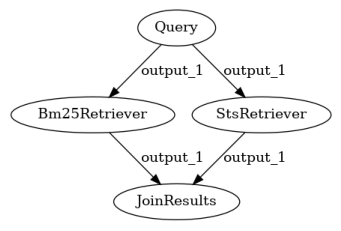

In [ ]:
util_pipeline.imprime_pipe(pipe_join_sts_multihop_bm25)

# Experiments

In [46]:
pipes

{'indir_juris_tcu': [{'PIPE_OBJECT': <haystack.pipelines.base.Pipeline at 0x7f775230dd90>,
   'RETRIEVER_TYPE': 'sts',
   'RANKER_TYPE': 'MINILM_INDIR',
   'RANKER_MODEL_NAME': '',
   'RETRIEVER_MODEL_NAME': ''}],
 'indir_juris_tcu_term': [{'PIPE_OBJECT': <haystack.pipelines.base.Pipeline at 0x7f775244e850>,
   'RETRIEVER_TYPE': 'sts',
   'RANKER_TYPE': 'MINILM_INDIR',
   'RANKER_MODEL_NAME': '',
   'RETRIEVER_MODEL_NAME': ''}],
 'indir_juris_tcu_synonym': [{'PIPE_OBJECT': <haystack.pipelines.base.Pipeline at 0x7f775b582710>,
   'RETRIEVER_TYPE': 'sts',
   'RANKER_TYPE': 'MINILM_INDIR',
   'RANKER_MODEL_NAME': '',
   'RETRIEVER_MODEL_NAME': ''}],
 'indir_juris_tcu_related_term': [{'PIPE_OBJECT': <haystack.pipelines.base.Pipeline at 0x7f775b61d590>,
   'RETRIEVER_TYPE': 'sts',
   'RANKER_TYPE': 'MINILM_INDIR',
   'RANKER_MODEL_NAME': '',
   'RETRIEVER_MODEL_NAME': ''}],
 'indir_juris_tcu_synonym_related_term': [{'PIPE_OBJECT': <haystack.pipelines.base.Pipeline at 0x7f77500a0950>,
   'RE

In [48]:
grid_experiment = { 
             'TOPK_RETRIEVER' : [300],
             'TOPK_RANKER' : [0],
             'DONE': [False]
}

In [49]:
list_experiment = [dict(zip(grid_experiment.keys(), values)) for values in product(*grid_experiment.values())]


In [50]:
print(len(list_experiment))
gc.collect()

1


105

In [51]:
pipes['indir_juris_tcu'][0].keys()

dict_keys(['PIPE_OBJECT', 'RETRIEVER_TYPE', 'RANKER_TYPE', 'RANKER_MODEL_NAME', 'RETRIEVER_MODEL_NAME'])

In [52]:
df_search_data.head()

,index,ID,TEXT,RELEVANCE_DICT,SOURCE
0,0,1,técnica e preço,"{21064: 3, 42166: 3, 13702: 3, 20592: 3, 15740: 3, 53641: 3, 31601: 3, 54765: 3, 20506: 3, 47161: 3, 161: 1, 11595: 1, 40647: 1, 22155: 1, 18435: 1}",search log
1,1,2,restos a pagar,"{31437: 3, 19340: 3, 77959: 3, 17289: 2, 18452: 2, 18105: 1, 19636: 1, 31274: 0, 17258: 0, 32865: 0, 19738: 0, 104484: 0, 90647: 0, 21876: 0, 33096: 0}",search log
2,2,3,aditivo a contrato,"{18380: 3, 31102: 3, 17240: 3, 20511: 3, 32589: 3, 20510: 3, 17816: 3, 18058: 2, 17225: 2, 57354: 2, 18003: 2, 3881: 2, 31096: 1, 20901: 1, 11621: 1}",search log
3,3,4,adesão a ata de registro de preços,"{16895: 3, 45015: 3, 14526: 3, 62306: 3, 6237: 3, 50537: 3, 16981: 3, 21201: 3, 77927: 3, 84935: 3, 22098: 1, 18410: 1, 8858: 1, 60811: 0, 42906: 0}",search log
4,4,5,sobrepreço e superfaturamento,"{21172: 3, 17816: 3, 4066: 3, 53003: 3, 94290: 3, 114656: 3, 50616: 3, 144170: 3, 16277: 3, 59226: 3, 18047: 2, 31612: 1, 18036: 1, 42583: 0, 29387: 0}",search log


In [ ]:
raise Exception ('Stop execution - create only desired pipelines in code below ')

Exception: Stop execution - create only desired pipelines in code below 

In [54]:
importlib.reload(util_experiment)

<module 'util.util_experiment_juris_tcu' from '/home/borela/fontes/ind-ir/code/util/util_experiment_juris_tcu.py'>

In [55]:
%%time
# colocar pequeno só para testes, depois voltar para 9999999 (número maior do que o número de termos a pesquisar)
limit_query =  9999999 # 100 # 
for index_name in pipes.keys():
    for pipe in pipes[index_name]:
        for cnt, experiment in enumerate(list_experiment):
            list_result_experiment = [] # por experiment
            experiment['INDEX_NAME'] = index_name
            experiment['PIPE'] = pipe
            print(f"==={cnt}/{len(list_experiment)}===>  {time.strftime('%Y-%b-%d %H:%M:%S')} experiment: {experiment}")
            result_run = util_experiment.experiment_run(parm_df=df_search_data, 
                                                    parm_experiment=experiment,
                                                    parm_limit_query=limit_query,
                                                    parm_print=True)
            list_result_experiment.append(result_run)
            # print(f"qtd_encontrado sim:{result_run['qtd_encontrado']}, não:{result_run['qtd_nao_encontrado']} ({result_run['percent_nao_encontrado']}%)")
            experiment['DONE'] = True
            util_experiment.add_experiment_result(parm_list_result=list_result_experiment, parm_dataset='juris_tcu')
            torch.cuda.empty_cache()

===0/1===>  2023-Jun-27 13:07:52 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'DONE': False, 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f775230dd90>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:08<00:00,  2.20it/s]


COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 4
RANK1_MEAN: 3.562
NDCG@5_MEAN: 43.275
NDCG@10_MEAN: 40.034
NDCG@15_MEAN: 41.465
NDCG@20_MEAN: 43.489
PRECISION@50_MEAN: 9.2
PRECISION@100_MEAN: 5.113
RECALL@50_MEAN: 30.667
RECALL@100_MEAN: 34.089
TIME_SPENT_MEAN: 0.454
===0/1===>  2023-Jun-27 13:09:01 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'DONE': True, 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f775244e850>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:20<00:00,  1.86it/s]


COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 2
RANK1_MEAN: 4.277
NDCG@5_MEAN: 49.559
NDCG@10_MEAN: 45.35
NDCG@15_MEAN: 47.768
NDCG@20_MEAN: 50.23
PRECISION@50_MEAN: 10.6
PRECISION@100_MEAN: 5.7
RECALL@50_MEAN: 35.333
RECALL@100_MEAN: 38.0
TIME_SPENT_MEAN: 0.538
===0/1===>  2023-Jun-27 13:10:22 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'DONE': True, 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f775b582710>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:43<00:00,  1.45it/s]


COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 3
RANK1_MEAN: 7.673
NDCG@5_MEAN: 40.21
NDCG@10_MEAN: 35.418
NDCG@15_MEAN: 37.657
NDCG@20_MEAN: 39.594
PRECISION@50_MEAN: 8.96
PRECISION@100_MEAN: 5.12
RECALL@50_MEAN: 29.867
RECALL@100_MEAN: 34.133
TIME_SPENT_MEAN: 0.689
===0/1===>  2023-Jun-27 13:12:06 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'DONE': True, 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f775b61d590>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:28<00:00,  1.01it/s]


COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 8
RANK1_MEAN: 11.155
NDCG@5_MEAN: 23.168
NDCG@10_MEAN: 22.387
NDCG@15_MEAN: 24.446
NDCG@20_MEAN: 26.683
PRECISION@50_MEAN: 7.147
PRECISION@100_MEAN: 4.467
RECALL@50_MEAN: 23.822
RECALL@100_MEAN: 29.778
TIME_SPENT_MEAN: 0.989
===0/1===>  2023-Jun-27 13:14:34 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'DONE': True, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7f77500a0950>, 'RETRIEVER_TYPE': 'sts', 'RANKER_TYPE': 'MINILM_INDIR', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:39<00:00,  1.06s/it]


COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 11
RANK1_MEAN: 14.338
NDCG@5_MEAN: 19.627
NDCG@10_MEAN: 18.901
NDCG@15_MEAN: 20.619
NDCG@20_MEAN: 21.973
PRECISION@50_MEAN: 6.48
PRECISION@100_MEAN: 4.047
RECALL@50_MEAN: 21.6
RECALL@100_MEAN: 26.978
TIME_SPENT_MEAN: 1.065
CPU times: user 8min 47s, sys: 2.36 s, total: 8min 49s
Wall time: 9min 22s


In [ ]:
%%time
# colocar pequeno só para testes, depois voltar para 9999999 (número maior do que o número de termos a pesquisar)
limit_query =  9999999 # 100 # 
for index_name in pipes.keys():
    for pipe in pipes[index_name]:
        for cnt, experiment in enumerate(list_experiment):
            list_result_experiment = [] # por experiment
            experiment['INDEX_NAME'] = index_name
            experiment['PIPE'] = pipe
            print(f"==={cnt}/{len(list_experiment)}===>  {time.strftime('%Y-%b-%d %H:%M:%S')} experiment: {experiment}")
            result_run = util_experiment.experiment_run(parm_df=df_search_data, 
                                                    parm_experiment=experiment,
                                                    parm_limit_query=limit_query,
                                                    parm_print=True)
            list_result_experiment.append(result_run)
            # print(f"qtd_encontrado sim:{result_run['qtd_encontrado']}, não:{result_run['qtd_nao_encontrado']} ({result_run['percent_nao_encontrado']}%)")
            experiment['DONE'] = True
            util_experiment.add_experiment_result(parm_list_result=list_result_experiment, parm_dataset='juris_tcu')

===0/1===>  2023-Jun-27 11:48:30 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'DONE': False, 'INDEX_NAME': 'indir_juris_tcu', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe46db6ea90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:07<00:00,  2.23it/s]


COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.513
NDCG@5_MEAN: 46.229
NDCG@10_MEAN: 43.832
NDCG@15_MEAN: 47.097
NDCG@20_MEAN: 49.708
PRECISION@50_MEAN: 12.333
PRECISION@100_MEAN: 7.16
RECALL@50_MEAN: 41.111
RECALL@100_MEAN: 47.733
TIME_SPENT_MEAN: 0.449
===0/1===>  2023-Jun-27 11:49:37 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'DONE': True, 'INDEX_NAME': 'indir_juris_tcu_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe4770f3fd0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:14<00:00,  2.03it/s]


COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.987
NDCG@5_MEAN: 51.656
NDCG@10_MEAN: 49.246
NDCG@15_MEAN: 51.426
NDCG@20_MEAN: 54.309
PRECISION@50_MEAN: 13.213
PRECISION@100_MEAN: 7.407
RECALL@50_MEAN: 44.044
RECALL@100_MEAN: 49.378
TIME_SPENT_MEAN: 0.493
===0/1===>  2023-Jun-27 11:50:52 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'DONE': True, 'INDEX_NAME': 'indir_juris_tcu_synonym', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe46daa7e90>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [01:32<00:00,  1.63it/s]


COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 10.66
NDCG@5_MEAN: 38.415
NDCG@10_MEAN: 36.067
NDCG@15_MEAN: 37.738
NDCG@20_MEAN: 40.002
PRECISION@50_MEAN: 10.613
PRECISION@100_MEAN: 6.553
RECALL@50_MEAN: 35.378
RECALL@100_MEAN: 43.689
TIME_SPENT_MEAN: 0.614
===0/1===>  2023-Jun-27 11:52:24 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'DONE': True, 'INDEX_NAME': 'indir_juris_tcu_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe4773d62d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:14<00:00,  1.11it/s]


COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 11.94
NDCG@5_MEAN: 22.381
NDCG@10_MEAN: 23.143
NDCG@15_MEAN: 24.975
NDCG@20_MEAN: 27.045
PRECISION@50_MEAN: 9.147
PRECISION@100_MEAN: 5.953
RECALL@50_MEAN: 30.489
RECALL@100_MEAN: 39.689
TIME_SPENT_MEAN: 0.899
===0/1===>  2023-Jun-27 11:54:40 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'DONE': True, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term', 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.base.Pipeline object at 0x7fe476dff450>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'MINILM_INDIR', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [02:30<00:00,  1.00s/it]


COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 13.367
NDCG@5_MEAN: 19.506
NDCG@10_MEAN: 19.313
NDCG@15_MEAN: 21.661
NDCG@20_MEAN: 24.058
PRECISION@50_MEAN: 8.187
PRECISION@100_MEAN: 5.76
RECALL@50_MEAN: 27.289
RECALL@100_MEAN: 38.4
TIME_SPENT_MEAN: 1.004
CPU times: user 9min 17s, sys: 2.96 s, total: 9min 20s
Wall time: 8min 40s


In [ ]:
%%time
# colocar pequeno só para testes, depois voltar para 9999999 (número maior do que o número de termos a pesquisar)
limit_query =  9999999 # 100 # 
for index_name in pipes.keys():
    for pipe in pipes[index_name]:
        for cnt, experiment in enumerate(list_experiment):
            list_result_experiment = [] # por experiment
            experiment['INDEX_NAME'] = index_name
            experiment['PIPE'] = pipe
            print(f"==={cnt}/{len(list_experiment)}===>  {time.strftime('%Y-%b-%d %H:%M:%S')} experiment: {experiment}")
            result_run = util_experiment.experiment_run(parm_df=df_search_data, 
                                                    parm_experiment=experiment,
                                                    parm_limit_query=limit_query,
                                                    parm_print=True)
            list_result_experiment.append(result_run)
            # print(f"qtd_encontrado sim:{result_run['qtd_encontrado']}, não:{result_run['qtd_nao_encontrado']} ({result_run['percent_nao_encontrado']}%)")
            experiment['DONE'] = True
            util_experiment.add_experiment_result(parm_list_result=list_result_experiment, parm_dataset='juris_tcu')

===0/1===>  2023-Jun-27 00:23:39 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'DONE': True, 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f3144caf4d0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'INDEX_NAME': 'indir_juris_tcu'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.22it/s]


COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.853
NDCG@5_MEAN: 59.411
NDCG@10_MEAN: 55.158
NDCG@15_MEAN: 58.502
NDCG@20_MEAN: 61.256
PRECISION@50_MEAN: 12.92
PRECISION@100_MEAN: 7.127
RECALL@50_MEAN: 43.067
RECALL@100_MEAN: 47.511
TIME_SPENT_MEAN: 0.122
===0/1===>  2023-Jun-27 00:23:58 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'DONE': True, 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f3144c26dd0>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'INDEX_NAME': 'indir_juris_tcu_term'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.33it/s]


COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.58
NDCG@5_MEAN: 59.011
NDCG@10_MEAN: 55.707
NDCG@15_MEAN: 58.925
NDCG@20_MEAN: 61.785
PRECISION@50_MEAN: 13.533
PRECISION@100_MEAN: 7.373
RECALL@50_MEAN: 45.111
RECALL@100_MEAN: 49.156
TIME_SPENT_MEAN: 0.12
===0/1===>  2023-Jun-27 00:24:16 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'DONE': True, 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f313c1b9490>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'INDEX_NAME': 'indir_juris_tcu_synonym'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:17<00:00,  8.36it/s]


COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 2.647
NDCG@5_MEAN: 58.332
NDCG@10_MEAN: 55.239
NDCG@15_MEAN: 57.717
NDCG@20_MEAN: 60.345
PRECISION@50_MEAN: 13.533
PRECISION@100_MEAN: 7.373
RECALL@50_MEAN: 45.111
RECALL@100_MEAN: 49.156
TIME_SPENT_MEAN: 0.12
===0/1===>  2023-Jun-27 00:24:34 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'DONE': True, 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f313c1b9610>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'INDEX_NAME': 'indir_juris_tcu_related_term'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.03it/s]


COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 4.187
NDCG@5_MEAN: 54.735
NDCG@10_MEAN: 51.054
NDCG@15_MEAN: 53.283
NDCG@20_MEAN: 56.303
PRECISION@50_MEAN: 12.573
PRECISION@100_MEAN: 7.093
RECALL@50_MEAN: 41.911
RECALL@100_MEAN: 47.289
TIME_SPENT_MEAN: 0.125
===0/1===>  2023-Jun-27 00:24:53 experiment: {'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'DONE': True, 'PIPE': {'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f313c1b9790>, 'RETRIEVER_TYPE': 'bm25', 'RANKER_TYPE': 'none', 'RANKER_MODEL_NAME': '', 'RETRIEVER_MODEL_NAME': ''}, 'INDEX_NAME': 'indir_juris_tcu_synonym_related_term'}
Experimento envolverá 150 registros, toda a base de dados


100%|██████████| 150/150 [00:18<00:00,  8.00it/s]


COUNT_QUERY_RUN: 150
COUNT_QUERY_WITHOUT_RESULT: 0
COUNT_QUERY_NOT_FOUND: 0
RANK1_MEAN: 3.42
NDCG@5_MEAN: 55.498
NDCG@10_MEAN: 52.204
NDCG@15_MEAN: 54.757
NDCG@20_MEAN: 57.39
PRECISION@50_MEAN: 12.907
PRECISION@100_MEAN: 7.113
RECALL@50_MEAN: 43.022
RECALL@100_MEAN: 47.422
TIME_SPENT_MEAN: 0.125
CPU times: user 6.88 s, sys: 56 ms, total: 6.93 s
Wall time: 1min 33s


Free resources: 

In [ ]:
quit()

: 